# Project 4b - Molecular Simulation: N-bodies and emergent properties

## Due date TBD

With working code for an $n$-molecule simulation in place (along with periodic boundary conditions) we can start to examine some interesting cases.  In particular, we will perform simulations corresponding to materials in the gas, liquid, and solid phases.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as numba
import ode_methods as om

Integrator = om.Integrator
Cromer = om.Cromer
PBCCallback = om.PBCCallback
LennardJones = om.LennardJones
periodic_distance = om.periodic_distance

### Random placement - gas
One of the trickiest aspects of molecular dynamics simulations is the specification of initial conditions.  This is a result of the strong repulsive forces of the Lennard-Jones force.  If particles are randomly placed too close together, we'll get a rather extreme force that will quickly turn into an unreasonably fast particle and the simulation will explode.  As such, **begin by devising a subroutine that randomly places $N$ particles such that no two are closer than $2^\frac{1}{6} \sigma$.**  Look at Gould 8.4 for inspiration.  Using this routine, randomly place 10 particles in a domain that is size $L\times L$, with $\sigma=\epsilon=1$.  Set initial velocities to normally-distributed random values with standard deviation $\sigma=5$.  Use a time step of $\Delta t=0.001$ and run the simulation for $10$ units of time.  

In [2]:
@numba.jit(nopython=True)
def randPositions(n_bodies, smallestDist, L):
    pos = np.zeros(2*n_bodies)
    for i in range(n_bodies-1):
        while True:
            overlap = False
            particle_i = np.random.uniform(0,L,2)
            j = 0 
            while(j < i and not overlap):
                particle_j = np.array([pos[j],pos[j+n_bodies]])
                dist_vec = periodic_distance(particle_i, particle_j,L)
                dist = np.sqrt(dist_vec[0]**2 + dist_vec[1]**2)
                if dist < smallestDist:
                    overlap = True
                    break
                j += 1;
            if not overlap:
                pos[i] = particle_i[0]
                pos[i+n_bodies] = particle_i[1]
                break
    return pos

In [3]:
numParticles = 40
masses = np.ones(numParticles)
sigma = 1.
epsilon = 1.
t_0 = 0.
t_end = 0.1
dt = 0.001
length = 10.
smallestDist = np.power(2,1/6)*sigma 
pos = randPositions(numParticles, smallestDist, length) # need random places such that none are closer than smallestDist
vel = np.random.normal(0, 5, 2*numParticles)
u_0 = np.concatenate((pos, vel), axis=0)


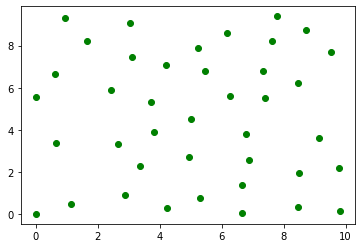

In [4]:
plt.plot(u_0[:numParticles], u_0[numParticles:2*numParticles], 'og')

In [12]:
position_indices = np.arange(2*numParticles)
callbacks = [PBCCallback(position_indices,length)]
LJ = LennardJones(m=masses, n_bodies=numParticles, sigma=sigma, epsilon=epsilon, L=length)
method = Cromer(callbacks)
integrator = Integrator(LJ,method)
t,u = integrator.integrate([t_0,t_end],dt,u_0)

<IPython.core.display.Javascript object>


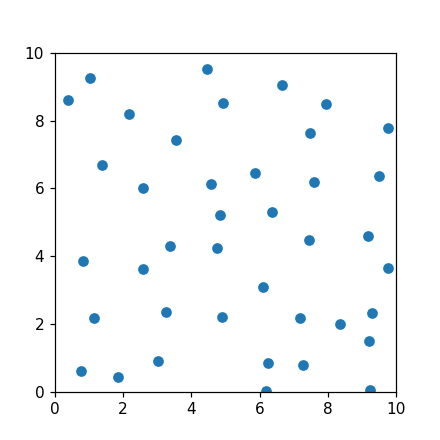

In [16]:
import matplotlib.animation as anim
import matplotlib.pyplot as plt
%matplotlib notebook

n = numParticles

fig,ax = plt.subplots()
fig.set_size_inches(4,4)

im = plt.plot(u[0,:n],u[0,n:2*n],'o')
ax.set_xlim(0,length)
ax.set_ylim(0,length)

def animate(frame_number):
#     pts = []
#     for i in range(n):
#         pts.append(u[0,i],u[0,i+n],colors[i])
#     newPts = tuple(pts)
#     print(pts)
#     im = plot(*newPts)
    im[0].set_xdata(u[frame_number,:n])
    im[0].set_ydata(u[frame_number,n:2*n])
    return im
    
animation = anim.FuncAnimation(fig, animate, frames=len(u), interval=100)

In [17]:
u.shape


(101, 160)

In [ ]:
temps = []
temperature_boltzman = 0
for i in range(len(u)):
    current_time = t[i]
    current_sum = 0
    sums = []
    for j in range(numParticles):
        velocity = u[i][numParticles*2+j] * u[i][numParticles*3+j]
        current_sum = (1 * velocity * current_time) * (velocity * current_time)
        sums.append(current_sum)
    temperature_boltzman = (1/(numParticles*length)) * np.sum(sums)
    temps.append(temperature_boltzman)

plt.plot(temps)
plt.show()

: 

Such dynamics correspond to a very diffuse gas (note the variable density in different portions of the domain).  Try increasing the density, i.e. by increasing the number of particles for the same size domain.  **How many particles can you add in this way before the randomized method stops working?**.  Why doesn't it work anymore?  

**Finally, at the maximum plausible number of particles, compute the temperature of the system through time, which is simply the average kinetic energy of all the particles (technically, proportional to, with the Boltzmann constant as the constant of proportionality, but this is really just a matter of changing units).  Does the kinetic energy change through time?  Does it find an equilibrium?**

### Rectangular lattice - the liquid phase
The situation above essentially corresponds to a vacuum: the pressure is close to zero because the particle are not squeezed together except during occasional repulsive interactions (**The pressure is proportional to the potential energy.  Add a routine to your LennardJones class that computes the Lennard-Jones potential, Gould Eq. 8.2**).  Non-interactive particles such as Argon thus tend to be gases at low pressures.  However, as we squeeze these particles together we can get them to behave like a liquid, which has a uniform density but where particles are still free to move around.  To simulate particles at higher pressure, we'll need to place them so that the density is greater than that achievable through random placment, but also such that the intermolecular forces approximately balance so that we don't get an explosion.  One reasonable starting configuration is a simple cartesian grid.  **Perform the same simulation as above, but with the particles initially placed on a grid with unit spacing.**  Accounting for periodic boundary conditions and again using $L=10$, this implies that you should have 100 particles.  

**Does the simulation that you produced correspond to the qualitative description of a liquid given in the previous paragraph?**.

### Energy loss - the solid phase
The system of particles here is approximately conservative, and so the temperature of the material (or rather the sum of the kinetic energy and potential energy) should remain constant (you can verify this fact if you wish): there is nowhere for that energy to go.  However, in real systems, heat is transferred from warm things to cool things.  In a macroscopic sense, this process is what you modelled with the coffee cup problem in Homework 1.  We can also do it in a microscopic sense here by including a non-conservative drag force of the form 
$$\mathbf{F}_d = -c_d \mathbf{v}.$$
Such a force is phenomenological, and not grounded in any physical principle, but roughly corresponds to the notion that kinetic energy should be lost to the surrounding medium (which we take to be at absolute zero) proportional to velocity.  **Modify your problem class to include such a drag force.  First, repeat the simulation above, but with a drag coefficient somewhere between 1 and 10.  Describe the configuration of the particles at the end of this simulation ([This](https://en.wikipedia.org/wiki/Close-packing_of_equal_spheres)) might be some helpful context).  Second, plot the temperature as a function of time and comment on how the shape of the curve compares to that of the cooling coffee cup from the homework.**




### Group self-assessment
This assignment is the culmination of our exploration of Newtonian physics, and we will be switching groups after this assignment.  Please describe the challenges and triumphs associated with completing this project.  Also, please describe how each group member contributed to the final project.
